In [ ]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Added for image processing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [ ]:
# For reproducibility
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Link Google Drive (uncomment the following lines if using Google Colab)
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Define paths
extracted_folder_path = '/content/drive/MyDrive/FER-2013/imagesV3/'
train_folder_path = '/content/drive/MyDrive/IST_691_Project_Data/FER-2013/imagesV3/train'
validation_folder_path = '/content/drive/MyDrive/IST_691_Project_Data/FER-2013/imagesV3/validation'
test_folder_path = '/content/drive/MyDrive/IST_691_Project_Data/FER-2013/imagesV3/test'

In [ ]:
# Function to count images per class in a directory
def count_images_in_directory(directory):
    """Count images per class in a directory"""
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [ ]:
# Check file counts in the train folder
train_counts = count_images_in_directory(train_folder_path)
print("Train Class Distribution:", train_counts)

Train Class Distribution: {'angry': 3995, 'disgust': 3608, 'fear': 4097, 'happy': 6552, 'neutral': 3972, 'sad': 3864, 'surprise': 2536}


In [ ]:
# Check file counts in the validation folder
val_counts = count_images_in_directory(validation_folder_path)
print("Validation Class Distribution:", val_counts)

Validation Class Distribution: {'surprise': 635, 'sad': 966, 'neutral': 993, 'happy': 1443, 'fear': 820, 'disgust': 88, 'angry': 799}


In [ ]:
# Check file counts in the test folder
folder_path_surprise = os.path.join(test_folder_path, 'surprise')
folder_path_sad = os.path.join(test_folder_path, 'sad')
folder_path_neutral = os.path.join(test_folder_path, 'neutral')
folder_path_happy = os.path.join(test_folder_path, 'happy')
folder_path_fear = os.path.join(test_folder_path, 'fear')
folder_path_disgust = os.path.join(test_folder_path, 'disgust')
folder_path_angry = os.path.join(test_folder_path, 'angry')

folder_list = [folder_path_surprise, folder_path_sad, folder_path_neutral, folder_path_happy, folder_path_fear, folder_path_disgust, folder_path_angry]
reportFileCounts = count_images_in_directory

test_counts = {folder.split('/')[-1]: len(os.listdir(folder)) for folder in folder_list}
print("Test Class Distribution:", test_counts)

Test Class Distribution: {'surprise': 831, 'sad': 1247, 'neutral': 1233, 'happy': 1774, 'fear': 1024, 'disgust': 111, 'angry': 957}


In [ ]:
# Create datasets using tf.data
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

def preprocess_image(file_path, label):
    """Load and preprocess image"""
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB format
    image = tf.image.resize(image, IMG_SIZE)        # Resize for model
    image = image / 255.0                           # Normalize pixel values
    return image, label

In [ ]:
# Load datasets
def create_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = create_dataset(train_folder_path)
validation_dataset = create_dataset(validation_folder_path)

Found 28624 files belonging to 7 classes.
Found 5744 files belonging to 7 classes.


In [ ]:
# Load pre-trained InceptionV3 as feature extractor
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom classifier layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(len(train_counts.keys()), activation='softmax')  # Number of classes
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Model Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,329,127 (85.18 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 767s 838ms/step - accuracy: 0.1684 - loss: 19.1748 - val_accuracy: 0.2509 - val_loss: 1.9418 - learning_rate: 1.0000e-04
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.1786 - loss: 2.4011 - val_accuracy: 0.2512 - val_loss: 1.9311 - learning_rate: 1.0000e-04
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.2193 - loss: 1.9961 - val_accuracy: 0.2512 - val_loss: 1.9230 - learning_rate: 1.0000e-04
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.2257 - loss: 1.9497 - val_accuracy: 0.2512 - val_loss: 1.9167 - learning_rate: 1.0000e-04
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.2276 - loss: 1.9321 - val_accuracy: 0.2512 - val_loss: 1.9119 - learning_rate: 1.0000e-04
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.2282 - loss: 1.9250 - val_accuracy: 0.2512 - val_loss: 1.9082 - learning_rate: 1.0000e-04
Epoch 7/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/

180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2476 - loss: 1.9024
Validation Accuracy: 25.12%


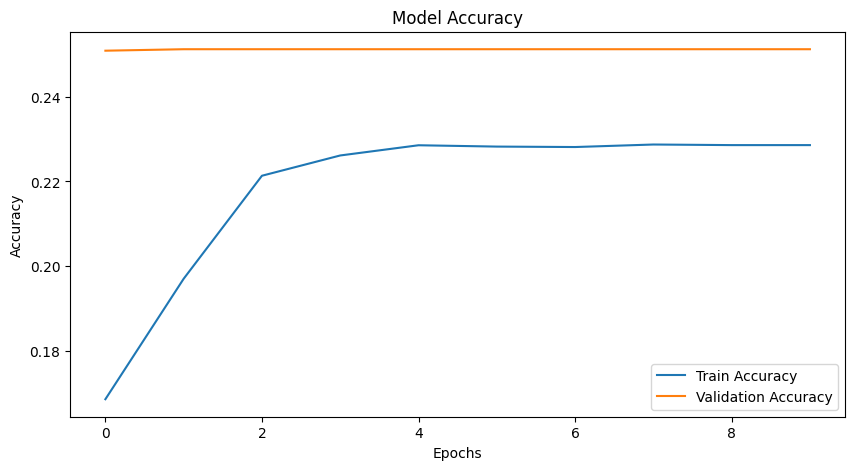

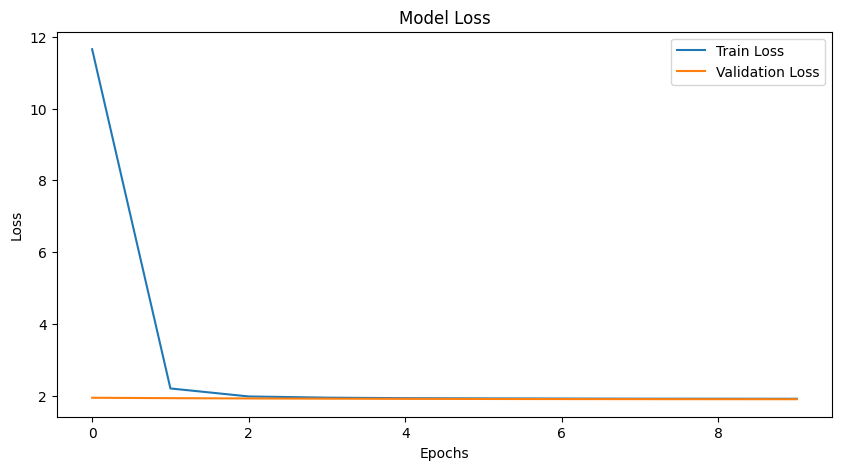

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Visualize Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze the first few layers (change range depending on results)
for layer in base_model.layers[:200]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 10
total_epochs = len(history.history['accuracy']) + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping, reduce_lr]
)


Epoch 10/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 105s 81ms/step - accuracy: 0.2285 - loss: 1.9108 - val_accuracy: 0.2533 - val_loss: 1.8599 - learning_rate: 1.0000e-05
Epoch 11/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.2335 - loss: 1.8717 - val_accuracy: 0.2650 - val_loss: 1.7919 - learning_rate: 1.0000e-05
Epoch 12/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.2427 - loss: 1.8205 - val_accuracy: 0.2779 - val_loss: 1.7133 - learning_rate: 1.0000e-05
Epoch 13/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.2656 - loss: 1.7467 - val_accuracy: 0.3182 - val_loss: 1.6584 - learning_rate: 1.0000e-05
Epoch 14/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 51s 56ms/step - accuracy: 0.2969 - loss: 1.6815 - val_accuracy: 0.3463 - val_loss: 1.5865 - learning_rate: 1.0000e-05
Epoch 15/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.3316 - loss: 1.6058 - val_accuracy: 0.3889 - val_loss: 1.5281 - learning_rate: 1.0000e-05
Epoch 16/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 49s 

In [ ]:


def remove_empty_files(directory):
    removed_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if os.path.getsize(file_path) == 0:  # Check for empty files
                os.remove(file_path)
                removed_files.append(file_path)
    return removed_files

# Clean test dataset
removed_files = remove_empty_files(test_folder_path)
print(f"Removed {len(removed_files)} empty files.")


Removed 0 empty files.


In [ ]:
# Evaluate the model on the test dataset
test_dataset = create_dataset(test_folder_path)

# Evaluate and print performance
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Found 7177 files belonging to 7 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 170s 751ms/step - accuracy: 0.4175 - loss: 1.6467
Test Accuracy: 42.43%
Test Loss: 1.6374


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

<Figure size 1000x800 with 0 Axes>

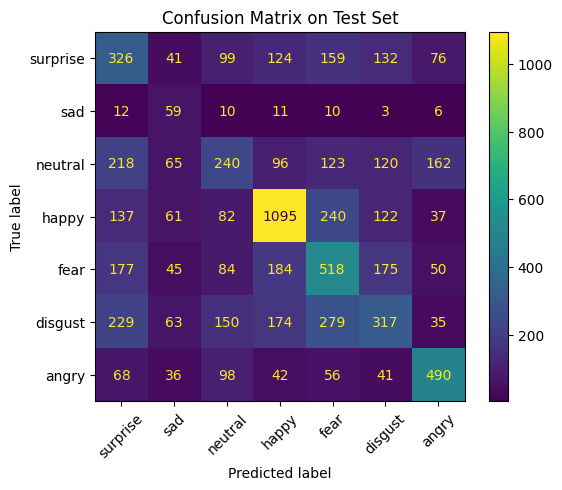

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict the test dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute confusion matrix
class_names = list(test_counts.keys())  # Class names from test folder
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

    surprise       0.28      0.34      0.31       957
         sad       0.16      0.53      0.25       111
     neutral       0.31      0.23      0.27      1024
       happy       0.63      0.62      0.63      1774
        fear       0.37      0.42      0.40      1233
     disgust       0.35      0.25      0.29      1247
       angry       0.57      0.59      0.58       831

    accuracy                           0.42      7177
   macro avg       0.38      0.43      0.39      7177
weighted avg       0.43      0.42      0.42      7177



In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Extract labels to compute class weights
train_labels = []
for images, labels in train_dataset:
    train_labels.extend(np.argmax(labels.numpy(), axis=1))

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Retrain the model with class weights
history_weighted = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Class Weights: {0: 1.0235651707491507, 1: 1.1333544504276212, 2: 0.9980822204400432, 3: 0.6241060526774812, 4: 1.029492159401525, 5: 1.0582667849748595, 6: 1.6124380351509688}
Epoch 1/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - accuracy: 0.6774 - loss: 0.9089 - val_accuracy: 0.5710 - val_loss: 1.2527 - learning_rate: 1.0000e-05
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.7122 - loss: 0.8066 - val_accuracy: 0.5888 - val_loss: 1.2218 - learning_rate: 1.0000e-05
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.7378 - loss: 0.7317 - val_accuracy: 0.5963 - val_loss: 1.2318 - learning_rate: 1.0000e-05
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.7655 - loss: 0.6597 - val_accuracy: 0.6109 - val_loss: 1.2528 - learning_rate: 1.0000e-05
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.7953 - loss: 0.5874 - val_accuracy: 0.6311 - val_loss: 1.2073 - learning_rate: 1.0000e-05
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


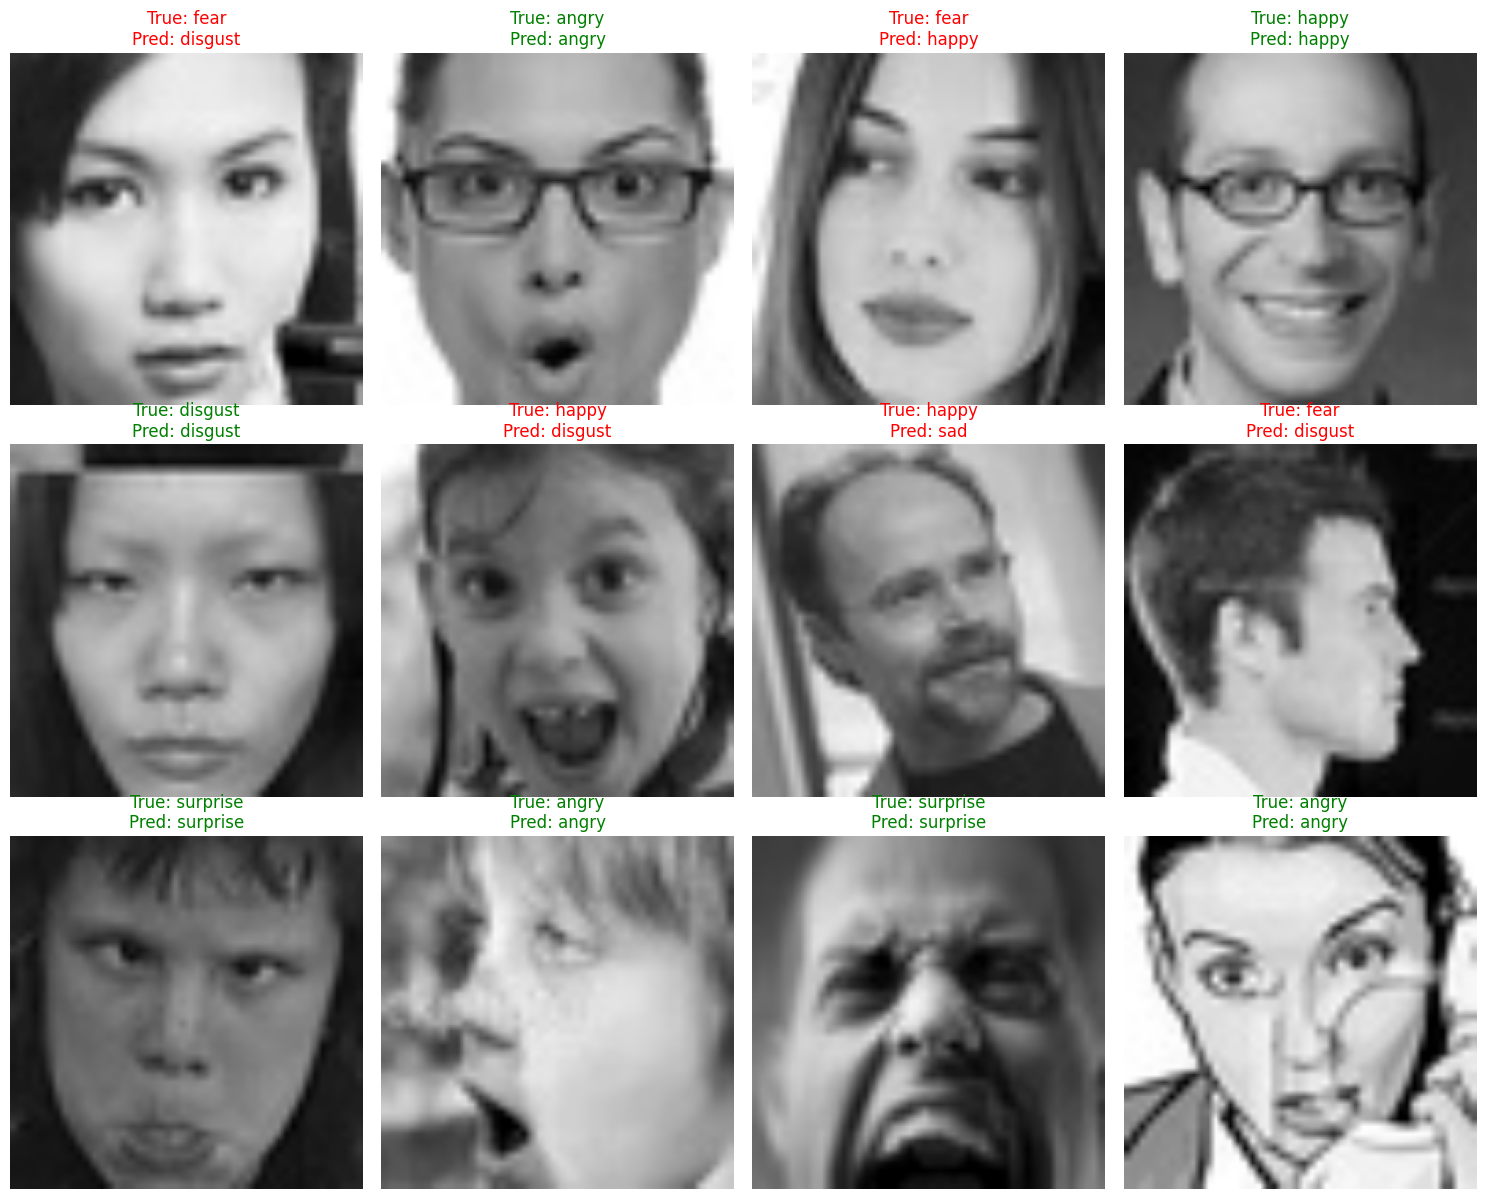

In [ ]:
import matplotlib.pyplot as plt

# Extract class names from folder names
class_names = list(test_counts.keys())

# Display predictions on a batch of test images
def display_predictions(dataset, model, class_names, num_images=12):
    plt.figure(figsize=(15, 12))
    for images, labels in dataset.take(1):  # Take one batch
        predictions = model.predict(images)
        for i in range(min(num_images, len(images))):
            plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_label = class_names[np.argmax(labels[i])]
            predicted_label = class_names[np.argmax(predictions[i])]
            color = "green" if true_label == predicted_label else "red"
            plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions
display_predictions(test_dataset, model, class_names)



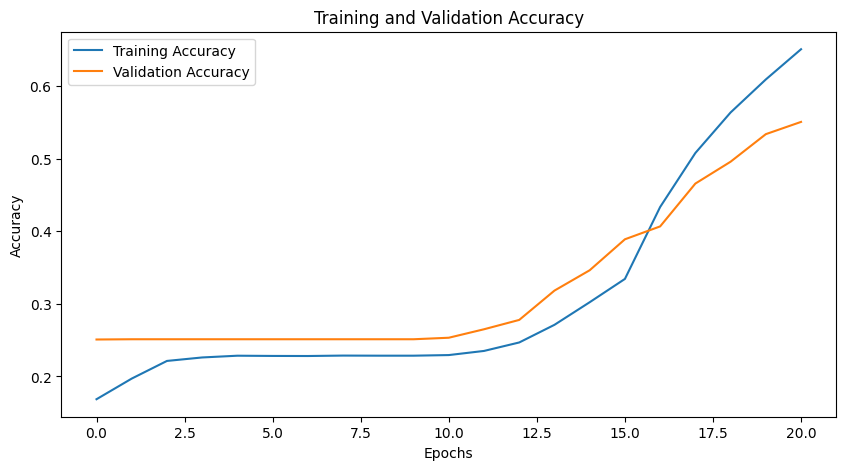

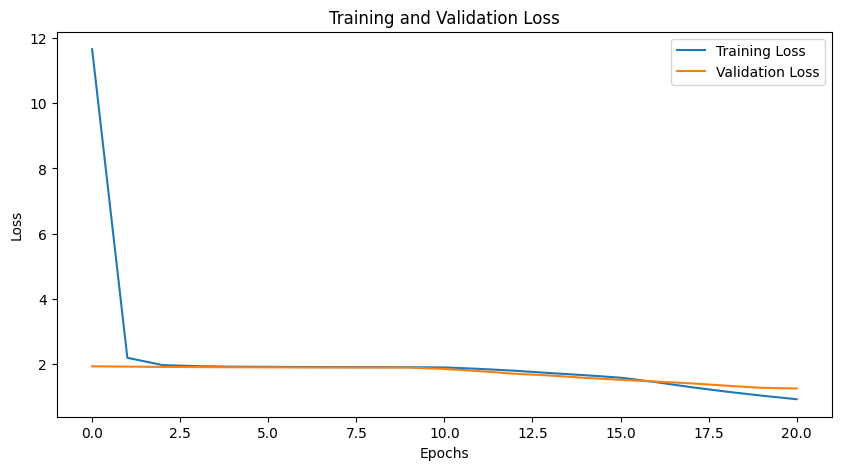

In [ ]:
# Plot fine-tuning accuracy and loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate class-wise accuracy
class_wise_accuracy = {}
for i, class_name in enumerate(class_names):
    true_class = np.array([y == i for y in y_true])
    pred_class = np.array([y == i for y in y_pred])
    class_wise_accuracy[class_name] = accuracy_score(true_class, pred_class)

# Display results
print("Class-wise Accuracy:")
for class_name, acc in class_wise_accuracy.items():
    print(f"{class_name}: {acc * 100:.2f}%")


Class-wise Accuracy:
surprise: 79.49%
sad: 94.94%
neutral: 81.79%
happy: 81.75%
fear: 77.96%
disgust: 78.78%
angry: 90.15%


In [ ]:
# Unfreeze more layers of the base model for deeper fine-tuning
base_model.trainable = True

# Freeze only the first 100 layers to allow fine-tuning of deeper layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with an even smaller learning rate
model.compile(optimizer=Adam(learning_rate=5e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model for 5 more epochs
fine_tune_epochs = 5
total_epochs = len(history_fine.history['accuracy']) + fine_tune_epochs

history_fine_tune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history_fine.epoch[-1],
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model again on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")



225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.4465 - loss: 1.9509
Final Test Accuracy: 45.37%
Final Test Loss: 1.9514


In [ ]:
# Function to remove 'disgust' class folder
def remove_disgust_class(base_path):
    disgust_path = os.path.join(base_path, 'disgust')
    if os.path.exists(disgust_path):
        os.system(f"rm -rf {disgust_path}")
        print(f"Removed 'disgust' class from {base_path}")
    else:
        print(f"No 'disgust' class found in {base_path}")

# Remove 'disgust' folder from train, validation, and test datasets
remove_disgust_class(train_folder_path)
remove_disgust_class(validation_folder_path)
remove_disgust_class(test_folder_path)

# Recreate datasets after removing 'disgust'
print("Recreating datasets after removing 'disgust'...")

train_dataset = create_dataset(train_folder_path)
validation_dataset = create_dataset(validation_folder_path)
test_dataset = create_dataset(test_folder_path)

# Confirm updated class distribution
print("Updated Train Class Distribution:", count_images_in_directory(train_folder_path))
print("Updated Validation Class Distribution:", count_images_in_directory(validation_folder_path))
print("Updated Test Class Distribution:", count_images_in_directory(test_folder_path))


Removed 'disgust' class from /content/drive/MyDrive/IST_691_Project_Data/FER-2013/imagesV3/train
Removed 'disgust' class from /content/drive/MyDrive/IST_691_Project_Data/FER-2013/imagesV3/validation
Removed 'disgust' class from /content/drive/MyDrive/IST_691_Project_Data/FER-2013/imagesV3/test
Recreating datasets after removing 'disgust'...
Found 25016 files belonging to 6 classes.
Found 5656 files belonging to 6 classes.
Found 7066 files belonging to 6 classes.
Updated Train Class Distribution: {'angry': 3995, 'fear': 4097, 'happy': 6552, 'neutral': 3972, 'sad': 3864, 'surprise': 2536}
Updated Validation Class Distribution: {'surprise': 635, 'sad': 966, 'neutral': 993, 'happy': 1443, 'fear': 820, 'angry': 799}
Updated Test Class Distribution: {'angry': 957, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


In [ ]:
# Update the final classification layer to 6 classes
model.pop()  # Remove the existing Dense layer
model.add(Dense(6, activation='softmax'))  # Add a new Dense layer for 6 classes

# Recompile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Re-train the model
history_updated = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,  # Adjust epochs as needed
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on the validation dataset
updated_loss, updated_accuracy = model.evaluate(validation_dataset)
print(f"Updated Validation Accuracy: {updated_accuracy * 100:.2f}%")
print(f"Updated Validation Loss: {updated_loss:.4f}")


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - accuracy: 0.2749 - loss: 2.7360 - val_accuracy: 0.4903 - val_loss: 1.4314 - learning_rate: 1.0000e-05
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.5644 - loss: 1.1641 - val_accuracy: 0.6296 - val_loss: 1.1137 - learning_rate: 1.0000e-05
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.7537 - loss: 0.7680 - val_accuracy: 0.6515 - val_loss: 1.0667 - learning_rate: 1.0000e-05
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.8136 - loss: 0.5644 - val_accuracy: 0.6798 - val_loss: 0.9918 - learning_rate: 1.0000e-05
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.8626 - loss: 0.4298 - val_accuracy: 0.6777 - val_loss: 1.0288 - learning_rate: 1.0000e-05
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.8818 - loss: 0.3639 - val_accuracy: 0.6772 - val_loss: 1.0703 - learning_rate: 1.0000e-05
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/s

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.4800 - loss: 1.6024
Test Accuracy: 48.66%
Test Loss: 1.5931


<Figure size 1000x800 with 0 Axes>

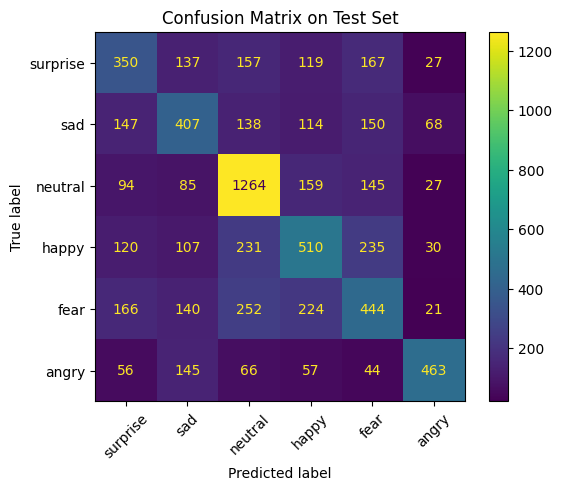

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Correct class names after removing 'disgust'
class_names = [class_name for class_name in test_counts.keys() if class_name != 'disgust']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()


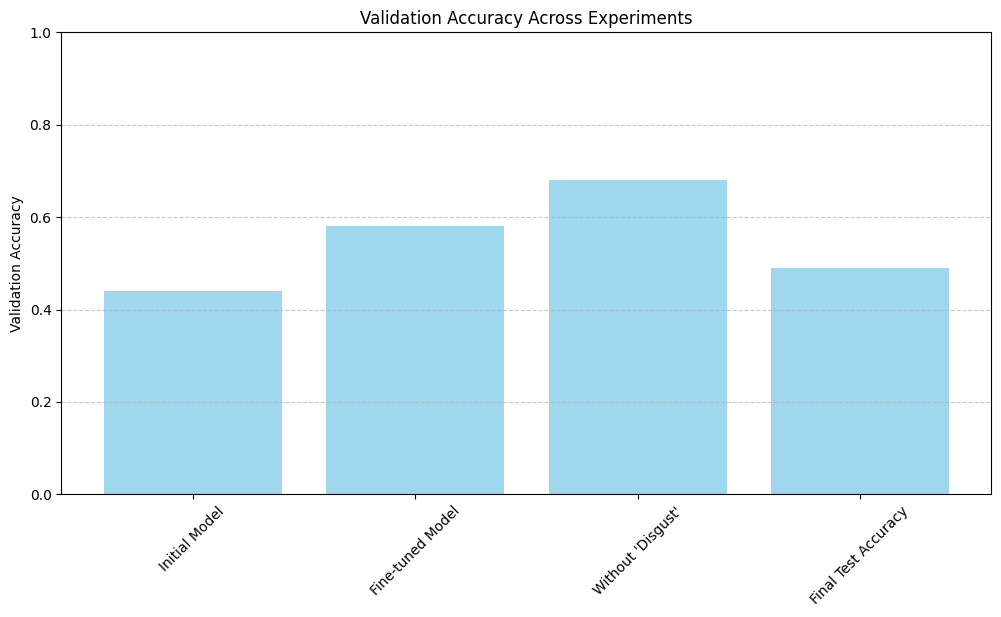

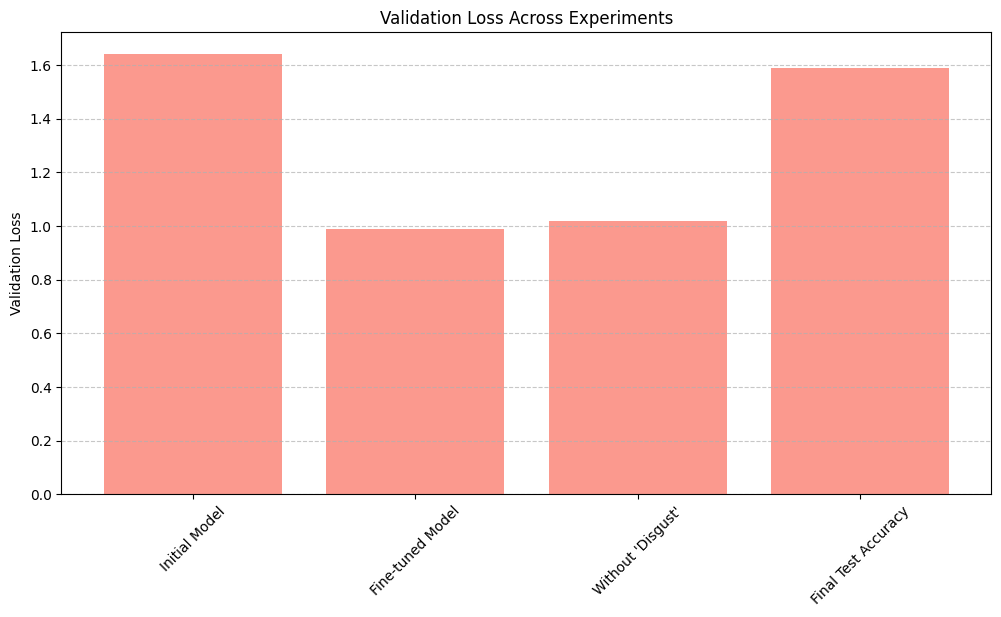

In [ ]:
# Summarize and visualize model performances across different experiments
experiments = [
    {"label": "Initial Model", "val_accuracy": 0.44, "val_loss": 1.64},  # Replace with actual values
    {"label": "Fine-tuned Model", "val_accuracy": 0.58, "val_loss": 0.99},
    {"label": "Without 'Disgust'", "val_accuracy": 0.68, "val_loss": 1.02},
    {"label": "Final Test Accuracy", "val_accuracy": 0.49, "val_loss": 1.59},
]

# Extract data for plotting
labels = [exp["label"] for exp in experiments]
val_accuracies = [exp["val_accuracy"] for exp in experiments]
val_losses = [exp["val_loss"] for exp in experiments]

# Create bar chart for accuracy
plt.figure(figsize=(12, 6))
plt.bar(labels, val_accuracies, color="skyblue", alpha=0.8)
plt.title("Validation Accuracy Across Experiments")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Create bar chart for loss
plt.figure(figsize=(12, 6))
plt.bar(labels, val_losses, color="salmon", alpha=0.8)
plt.title("Validation Loss Across Experiments")
plt.ylabel("Validation Loss")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
